# Urban Sounds Project

### Brief Description of the Classification Problem

The classification problem addressed in this project involves urban sound data classification. The dataset used is the urbansound8k dataset, consisting of 8732 labeled sound excerpts categorized into ten classes. The objective is to develop deep learning classifiers capable of accurately identifying the class to which a given sound excerpt belongs.

# Imports

In [1]:
import pandas as pd
import numpy as np
import re
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score


# Data pre-processing and preparation

### Obtaining the data

We used the following python script:

In [2]:
# python features.py

### Unifying the class labels with the data

In [3]:
datasets = [pd.read_csv(f'datasets/urbansounds_features_{i}.csv') for i in range(1, 11)]

In [4]:
for df in datasets:
    df['Label'] = df['Label'].str.split('-').str[1].astype(int)

### Check for object values

In [5]:
for df in datasets:
    object_columns = df.select_dtypes(include=['object']).columns
    print(object_columns)

Index(['fourier_tempogram'], dtype='object')
Index(['fourier_tempogram'], dtype='object')
Index(['fourier_tempogram'], dtype='object')
Index(['fourier_tempogram'], dtype='object')
Index(['fourier_tempogram'], dtype='object')
Index(['fourier_tempogram'], dtype='object')
Index(['fourier_tempogram'], dtype='object')
Index(['fourier_tempogram'], dtype='object')
Index(['fourier_tempogram'], dtype='object')
Index(['fourier_tempogram'], dtype='object')


### Convert the columns with object values to numeric

In [6]:
def calculate_mean_from_string(string):
    cleaned_string = string.replace('\n', '')
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", cleaned_string)
    array = np.array(numbers, dtype=float)
    mean_value = np.mean(array)
    return mean_value

In [7]:
for df in datasets:
    df['Label'] = df['Label'].astype('int64')

In [8]:
for df in datasets:
    df['fourier_tempogram'] = df['fourier_tempogram'].apply(calculate_mean_from_string)

### Check interval of the values per column

In [9]:
for df in datasets:
    column_intervals = df.describe().loc[['min', 'max']]
    print(column_intervals)

     chroma_stft  chroma_cqt  chroma_cens  melspectogram       rms  \
min     0.009734    0.150077     0.126660       0.017318  0.001788   
max     0.829676    0.768014     0.285653      30.430030  0.473862   

         centroid    bandwidth   contrast      flatness       rolloff  ...  \
min     50.916749    71.255507   5.698971  6.211397e-07    106.979450  ...   
max  10907.707763  7088.299210  24.957858  9.798845e-01  18628.717306  ...   

      mcffs_32   mcffs_33   mcffs_34   mcffs_35  mcffs_36   mcffs_37  \
min -11.730761 -13.273888 -15.653493  -9.955764 -6.521128 -21.866919   
max  11.225185   9.078557  15.806270  17.319443  9.707691  17.943160   

      mcffs_38  mcffs_39   mcffs_40  Label  
min -19.719917 -8.652861  -6.523879    0.0  
max   7.872053  7.306795  16.392504    9.0  

[2 rows x 54 columns]
     chroma_stft  chroma_cqt  chroma_cens  melspectogram       rms  \
min     0.008760    0.191508     0.136980       0.056502  0.004293   
max     0.841217    0.770370     0.2853

### Check the distribution of the classes

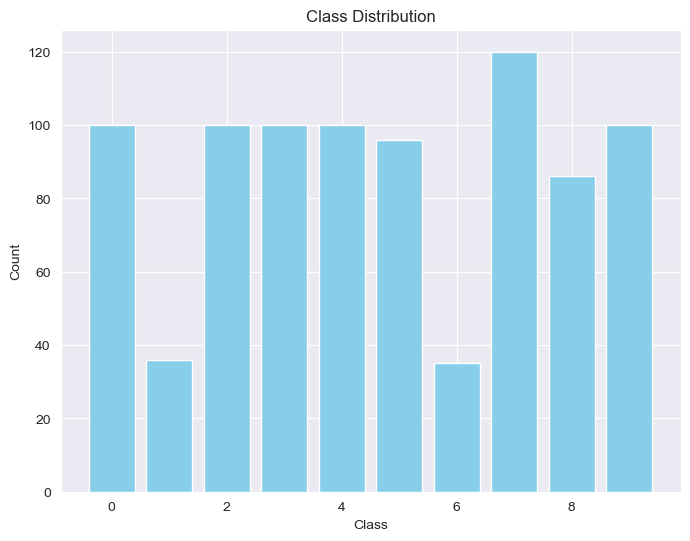

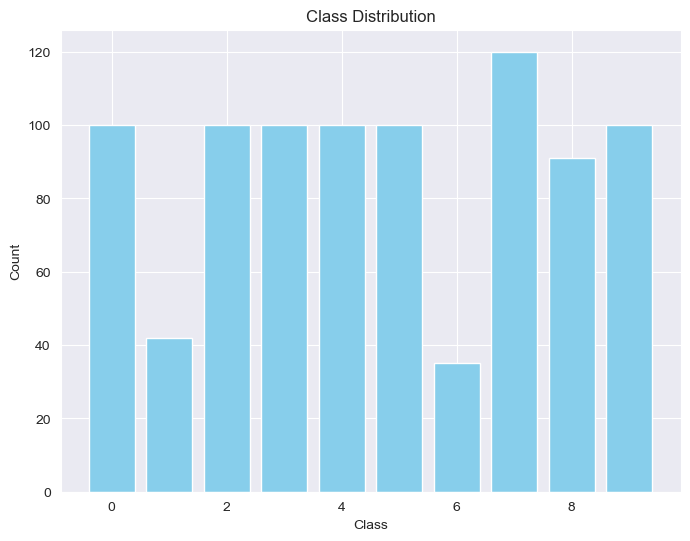

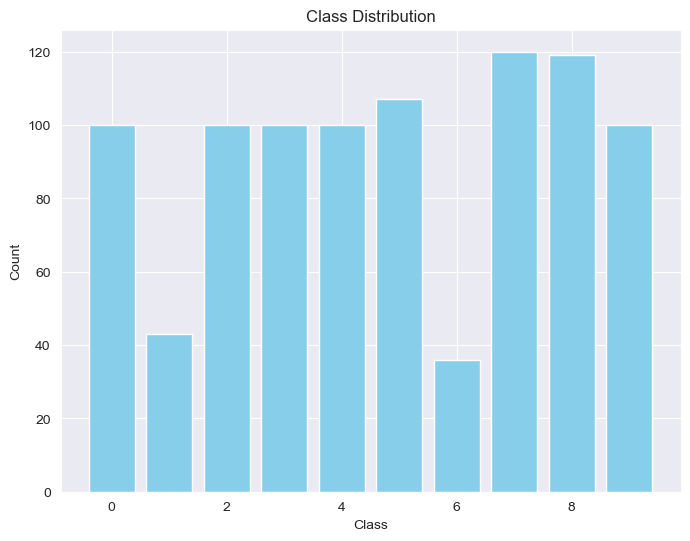

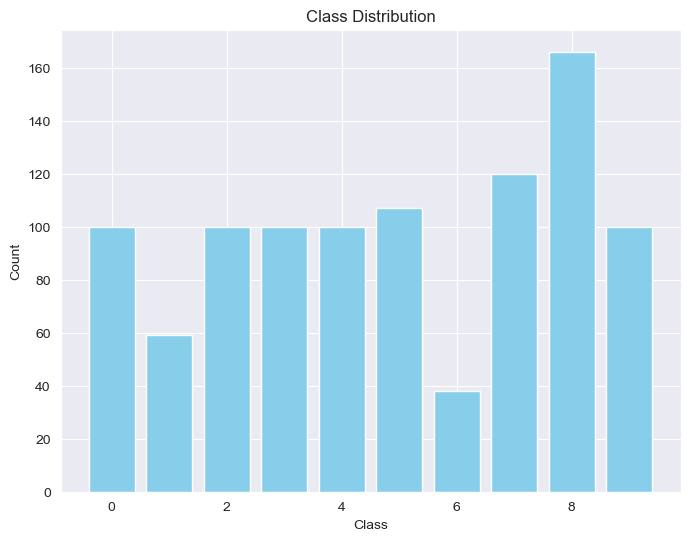

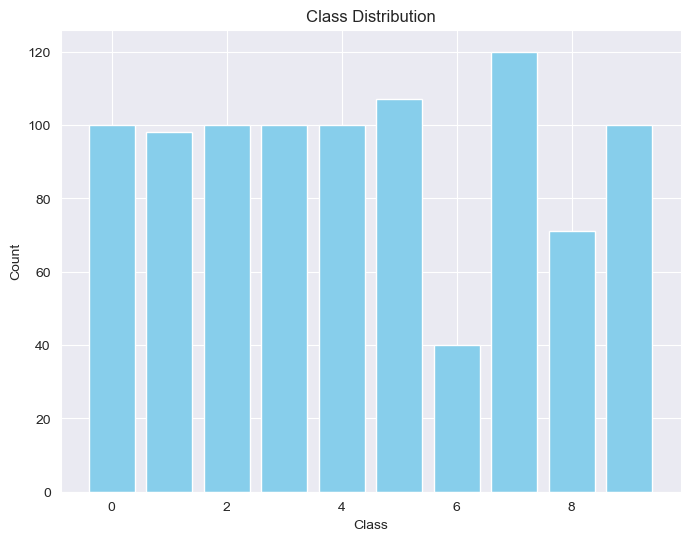

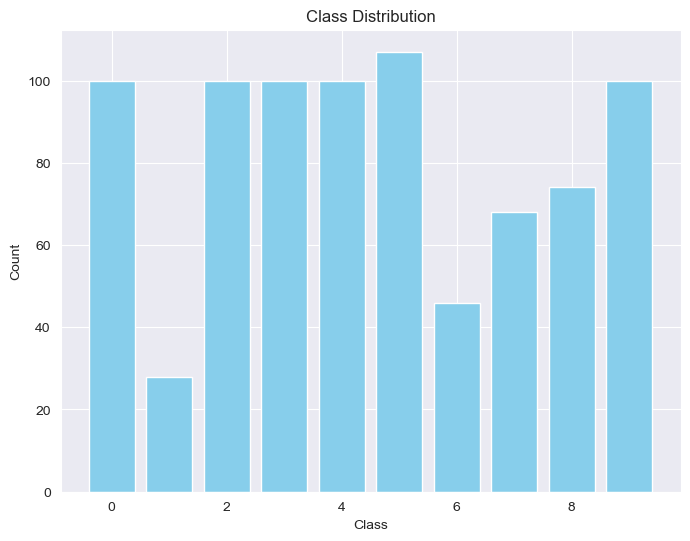

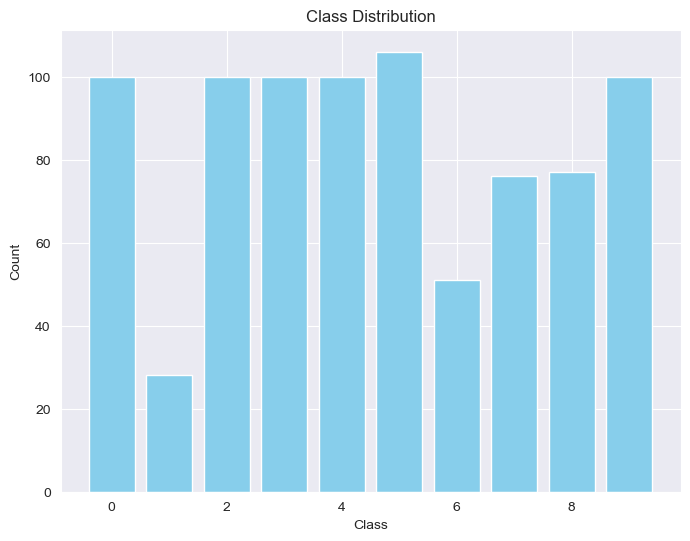

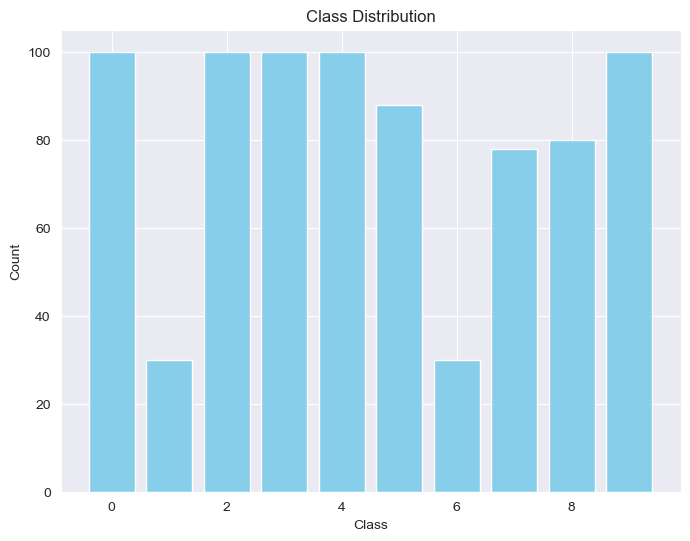

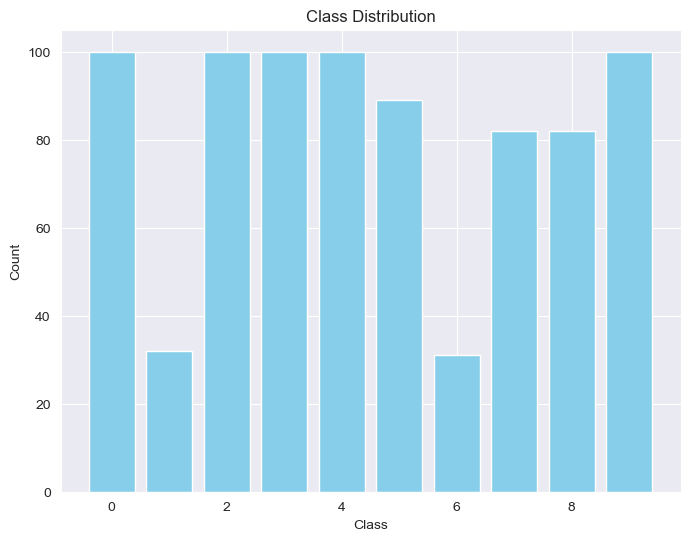

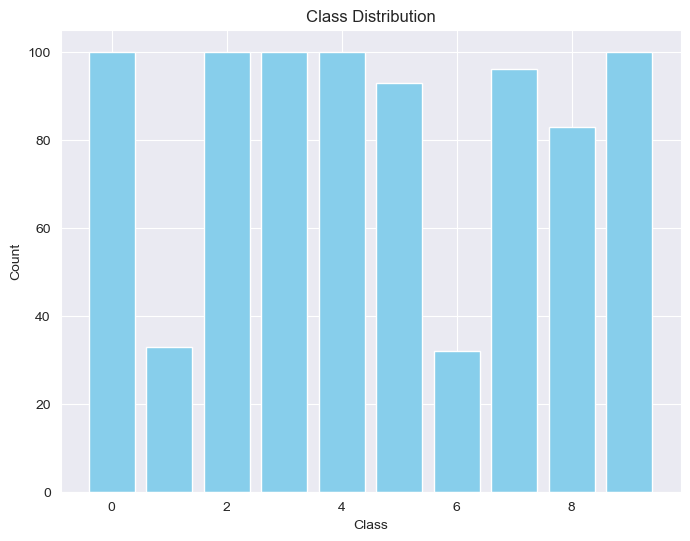

In [10]:
for df in datasets:
    class_counts = df['Label'].value_counts()
    class_labels = class_counts.index
    class_values = class_counts.values
    
    plt.figure(figsize=(8, 6))
    plt.bar(class_labels, class_values, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution')
    plt.show()

### The classes are not balanced nor normalized, so we will need adress that in the training set

# Model architecture definition

The classifiers we chose were the following: a classifier based on multilayer perceptron (MLP) and a convolutional neural network (CNN).

### MLP classifier

For the MLP classifier, we need to define the following parameters: number of layers, number of neurons
per layer and the activation function for each layer.

# Training strategy

We used the same training strategy for both models.

In order to define the details for the training strategies, we ran a grid search over some hyperparameters.
Choosing the best optimizer involves expererimenting and comparing the results of different optimizers to see what works best. We tested the following: SGD, Adam, and Adagrad.

To determine a good learning rate value, we tested some between the tradicional interval of 0.1 to 0.01.

Some common batch sizes of number of samples used in each iteration are 32, 64, 128 and we ended up testing all these values.

Too few epochs may result in underfitting, while too many epochs may lead to overfitting, so we tried 300 and got good results.

For early stopping, we tested patience levels of 3 and 6 and kept the rest of the parameters as default and for dropout rate we some in the range of 0 to 1.

L1_L2 regularization was the technique choosen by us for weigth regularization and we tested some values between 0 and 0.1.

For now we did not use any data augmentaion techniques neither transfer learning. 

After running the grid search, we found the best values for the parameters and proceeded to use them in the neural networks.

# Performance evaluation

In [14]:
# Print the updated shapes
shaped = [df.shape for df in datasets]
print(shaped)

[(873, 54), (888, 54), (925, 54), (990, 54), (936, 54), (823, 54), (838, 54), (806, 54), (816, 54), (837, 54)]


## CNN classifier

In [15]:
# Combine all labels from different datasets
all_labels = np.concatenate([df['Label'].values for df in datasets])

# Define the stratified k-fold
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [16]:
def oversample_features(X, y):
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled


def standardize_features(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled


def preprocess_data(dataset):
    X = dataset.drop('Label', axis=1)
    y = dataset['Label']

    # Oversample and standardize the features
    X_resampled, y_resampled = oversample_features(X, y)
    X_scaled = standardize_features(X_resampled)

    return X_scaled, y_resampled


def prepare_datasets(fold):
    # Prepare training dataset
    training_datasets = [dataset for index, dataset in enumerate(datasets) if index != fold]
    combined_df = pd.concat(training_datasets, ignore_index=True)
    X_train, y_train = preprocess_data(combined_df)

    # Prepare validation dataset
    validation_dataset = datasets[fold]
    X_val, y_val = preprocess_data(validation_dataset)

    return X_train, y_train, X_val, y_val

In [31]:
# Define hyperparameters
num_epochs = 201
dropout = 0.06
learning_rate = '0.1'
patience = 15
optimizer = 'adam'
regulizer = 0.1
batch_size = 64

cv_scores = []

mean_neurons = (X_train.shape[1] + len(np.unique(y_train))) // 2

for fold, (train_index, val_index) in enumerate(stratified_kfold.split(range(len(all_labels)), all_labels)):


    X_train, y_train, X_val, y_val = prepare_datasets(fold)
    print(len(X_train), len(y_train), len(X_val), len(y_val))

    X_train = X_train.reshape(2260, 53, 4)
    
    X_val = X_val.reshape(X_val.shape[0], 53, 1, 1)
    neurons_hidden_layer = int(2 / 3 * (X_train.shape[1] + len(np.unique(y_train))))

    # Define and compile the CNN model with hyperparameters
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu',
                               input_shape=(940,54,1)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=neurons_hidden_layer, activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=regulizer, l2=regulizer)),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(units=mean_neurons, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(units=len(np.unique(y_train)), activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)

    # Train the CNN model
    model.fit(X_train, y_train, validation_data=(X_val, y_val),
              batch_size=batch_size, epochs=num_epochs, callbacks=[early_stopping])

    # Evaluate the CNN model on the validation set
    y_val_pred_probs = model.predict(X_val)
    y_val_pred = np.argmax(y_val_pred_probs, axis=1)

    # Calculate and store accuracy for this fold
    fold_accuracy = accuracy_score(y_val, y_val_pred)
    cv_scores.append(fold_accuracy)

# Calculate and store the average accuracy for these hyperparameters
overall_average_accuracy = np.mean(cv_scores)


9040 9040 1200 1200


ValueError: Data cardinality is ambiguous:
  x sizes: 2260
  y sizes: 9040
Make sure all arrays contain the same number of samples.